In [52]:
#Load the libraries
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [53]:
#Load Data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [54]:
#Handle Missing Values Using Pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])
ratings[['userId', 'movieId', 'rating']] = pipe.fit_transform(ratings[['userId', 'movieId', 'rating']])

In [55]:
ratings['rating'].min()

0.5

In [56]:
ratings['rating'].max()

5.0

In [57]:

#Convert Data for Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [58]:
#Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [59]:
#Define Models & Hyperparameter Tuning with GridSearchCV
models = {
    'KNNBasic_Item': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}),
    'KNNBasic_User': KNNBasic(sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': SVD(),
}


In [60]:
param_grid = {
    'SVD': {'n_factors': [50, 100], 'reg_all': [0.02, 0.1]},
    'KNNBasic_Item': {'k': [20, 40], 'min_k': [3, 5]},
    'KNNBasic_User': {'k': [20, 40], 'min_k': [3, 5]}
}

best_scores = {}
best_params = {}

In [61]:
# Step 6: Train & Evaluate Each Model
for model_name, model in models.items():
    print(f"🔍 Tuning Hyperparameters for {model_name}...")
    grid_search = GridSearchCV(algo_class=type(model), param_grid=param_grid[model_name], measures=['rmse'], cv=5)
    grid_search.fit(data)
    
    best_scores[model_name] = grid_search.best_score['rmse']
    best_params[model_name] = grid_search.best_params['rmse']

🔍 Tuning Hyperparameters for KNNBasic_Item...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Compu

In [62]:
#select the best model
best_model_name = min(best_scores, key=best_scores.get)
best_model_params = best_params[best_model_name]

In [63]:
#Initialize the Best Model with Tuned Parameters & Train
if best_model_name == "SVD":
    best_model = SVD(**best_model_params)
elif best_model_name == "KNNBasic_Item":
    best_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, **best_model_params)
elif best_model_name == "KNNBasic_User":
    best_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True}, **best_model_params)

best_model.fit(trainset)

In [64]:
#Evaluate Model
predictions = best_model.test(testset)
rmse = accuracy.rmse(predictions)
print(f" Best Model: {best_model_name} with RMSE: {rmse:.4f}")

RMSE: 0.8775
 Best Model: SVD with RMSE: 0.8775


In [65]:
#Generate Top 5 Recommendations for a User
user_id = 1
movie_ids = ratings['movieId'].unique()
user_rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
movies_to_predict = [m for m in movie_ids if m not in user_rated_movies]

predictions = [best_model.predict(user_id, m) for m in movies_to_predict]
top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

In [66]:
#Display Recommendations
print(f"\n🎬 Top 5 Movie Recommendations for User {user_id}:")
titles, scores = [], []
for pred in top_n:
    title = movies[movies['movieId'] == pred.iid]['title'].values[0]
    print(f"{title} (Predicted Rating: {pred.est:.2f})")
    titles.append(title)
    scores.append(pred.est)


🎬 Top 5 Movie Recommendations for User 1:
Lawrence of Arabia (1962) (Predicted Rating: 4.98)
Shawshank Redemption, The (1994) (Predicted Rating: 4.98)
Cinema Paradiso (Nuovo cinema Paradiso) (1989) (Predicted Rating: 4.95)
Rear Window (1954) (Predicted Rating: 4.93)
Philadelphia Story, The (1940) (Predicted Rating: 4.92)


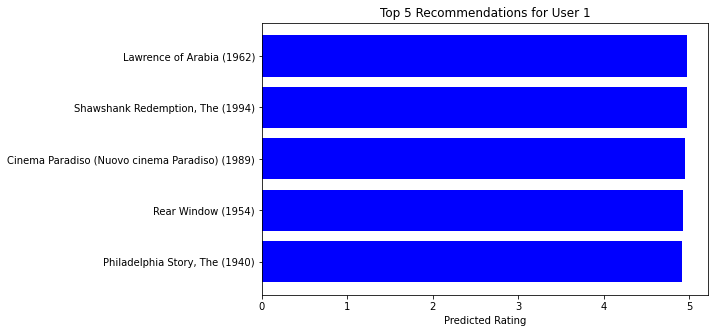

In [67]:
#Visualization
plt.figure(figsize=(8,5))
plt.barh(titles[::-1], scores[::-1], color='blue')
plt.xlabel('Predicted Rating')
plt.title(f"Top 5 Recommendations for User {user_id}")
plt.show()